In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statistics
import math
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Import data 

The following data was preprocessed in R, by merging eset_HTA20 and anoSC1_v11_nokey.csv

In [2]:
alldata = pd.read_csv("alldata.csv")

Check the data

In [3]:
alldata.head()

,Unnamed: 0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,...,g_32827,g_32828,g_32829,g_32830,SampleID,GA,Batch,Set,Train,Platform
0,1,6.062215,3.796484,5.849338,3.567779,6.166815,4.443027,5.836522,6.330018,4.922339,...,8.972873,10.440245,12.101476,13.695705,Tarca_001_P1A01,11.0,1,PRB_HTA,1,HTA20
1,2,6.125023,3.805305,6.191562,3.452524,5.678373,4.773199,6.143398,5.601745,4.711765,...,9.376194,10.845176,12.370891,13.635522,Tarca_003_P1A03,NaN,1,PRB_HTA,0,HTA20
2,3,5.875502,3.450245,6.550525,3.316134,6.185059,4.393488,5.898364,6.137984,4.628124,...,8.843612,10.493416,12.295786,13.616688,Tarca_004_P1A04,32.6,1,PRB_HTA,1,HTA20
3,4,6.126131,3.628411,6.421877,3.432451,5.633757,4.623783,6.019792,5.787502,4.796283,...,9.191471,10.879879,12.249936,13.524328,Tarca_005_P1A05,30.6,1,PRB_HTA,1,HTA20
4,5,6.146466,3.446812,6.260962,3.477162,5.313198,4.422651,6.407699,5.830437,4.726488,...,9.247768,10.754316,12.245458,13.509353,Tarca_006_P1A06,NaN,1,PRB_HTA,0,HTA20


# Make train and test dataset

In [4]:
X_train = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830'].values
X_train_df = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830']

In [5]:
y_train = alldata.loc[alldata['Train'] == 1, 'GA'].values
y_train_df = alldata.loc[alldata['Train'] == 1, 'GA']

In [49]:
# X_test = alldata.loc[alldata['Train'] == 0, 'g_1':'g_32830'].values
X_test_df = alldata.loc[alldata['Train'] == 0, 'g_1':'g_32830']
ID_test = alldata.loc[alldata['Train'] == 0, 'SampleID'].values

In [7]:
print(X_train.shape)
print(y_train.shape)

(367, 32830)
(367,)


# EDA

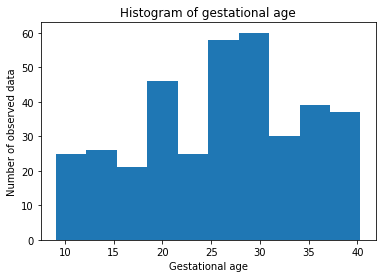

In [8]:
_ = plt.hist(y_train)
_ = plt.xlabel("Gestational age")
_ = plt.ylabel("Number of observed data")
_ = plt.title("Histogram of gestational age")
plt.show()

# Lasso regression

(32830,)
[ 0.  0. -0. -0. -0.]
[-0. -0. -0. -0. -0.]


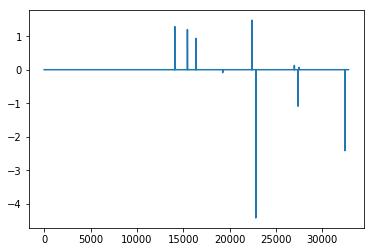

In [9]:
alpha = 0.1
lasso = Lasso(alpha = alpha, normalize = True)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_
print(lasso_coef.shape)
print(lasso_coef[0:5])
print(lasso_coef[32825:32831])
_ = plt.plot(lasso_coef)
plt.show()

In [10]:
COLUMNS = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830'].columns
var = pd.Series(COLUMNS[abs(lasso_coef) > 0.5])
coef = pd.Series(lasso_coef[abs(lasso_coef) > 0.5])
lasso_result = pd.concat(objs = [var, coef],
                         axis = 1,
                         keys = ['Variable', 'Lasso_coefficient'])
print(lasso_result)

  Variable  Lasso_coefficient
0  g_14088           1.287940
1  g_15452           1.197929
2  g_16391           0.931973
3  g_22398           1.476096
4  g_22824          -4.424946
5  g_27389          -1.089270
6  g_32432          -2.418021


# Trial prediction

DREAM rules predicted gestational age in fractional weeks up to one decimal place.

In [11]:
COLUMNS = lasso_result['Variable'].tolist()
X = X_train_df[COLUMNS].values
y = y_train
model = LinearRegression()
model.fit(X, y)
train_pred = model.predict(X).round(1)
result = pd.concat([pd.Series(y_train), pd.Series(train_pred)], 
                   axis = 1,
                   keys = ['GA_act', 'GA_pred'])
result.head()

,GA_act,GA_pred
0,11.0,12.2
1,32.6,33.4
2,30.6,23.6
3,26.1,22.6
4,22.6,24.6


# Training accuracy

DREAM judges by Root Mean Squared Error.

In [12]:
math.sqrt(statistics.mean((result['GA_act'] - result['GA_pred'])**2))

6.425040421208954

# Prediction in test data

In [13]:
COLUMNS = lasso_result['Variable'].tolist()
X_test = X_test_df[COLUMNS].values
test_pred = model.predict(X_test).round(1)
result = pd.concat([pd.Series(ID_test), pd.Series(test_pred)],
                  axis = 1,
                  keys = ['SampleID', 'GA'])
result.head()

,SampleID,GA
0,Tarca_003_P1A03,27.4
1,Tarca_006_P1A06,25.4
2,Tarca_011_P1A11,22.9
3,Tarca_012_P1A12,35.9
4,Tarca_015_P1B03,25.4


In [14]:
result['GA'].describe()

count    368.000000
mean      26.029076
std        5.683093
min        8.100000
25%       22.550000
50%       26.200000
75%       29.925000
max       42.800000
Name: GA, dtype: float64

# Adjustment

DREAM suggests that values are expected to be >8 and <42, so adjusts predicted values.
<br>
https://www.synapse.org/#!Synapse:syn18380862/wiki/590817

In [15]:
(result['GA'] >= 42).sum()

1

In [16]:
result.loc[result['GA'] >= 42, 'GA'] = 41.9

In [17]:
result.iloc[350]

SampleID    Tarca_844_P8D10
GA                     41.9
Name: 350, dtype: object

In [18]:
result['GA'].describe()

count    368.000000
mean      26.026630
std        5.676045
min        8.100000
25%       22.550000
50%       26.200000
75%       29.925000
max       41.900000
Name: GA, dtype: float64

# Export prediction

In [19]:
sub = result

In [20]:
# sub.to_csv('C:\\Users\\yukic\\Documents\\DREAM\\submission_190707.csv', index = False)

# Check relationship between response and selected features

In [21]:
COLUMNS = lasso_result['Variable'].tolist()
COLUMNS.append('GA')
df = alldata.loc[alldata['Train'] == 1, COLUMNS]
df.head()

,g_14088,g_15452,g_16391,g_22398,g_22824,g_27389,g_32432,GA
0,7.326387,4.405139,4.911448,8.828278,3.159517,5.849807,6.428600,11.0
2,8.033351,4.878254,6.225319,8.947091,2.675184,5.368895,5.923751,32.6
3,7.576564,4.396103,5.644666,8.804537,2.823732,5.646030,6.044667,30.6
5,8.541571,4.323788,5.553091,9.020144,2.904048,5.804934,6.412359,26.1
6,7.581693,4.180898,4.995425,9.294483,2.788135,5.802293,5.754789,22.6


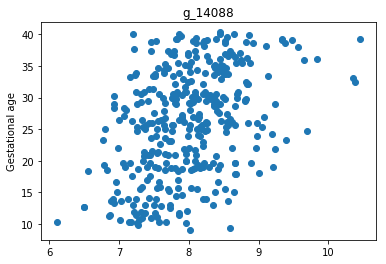

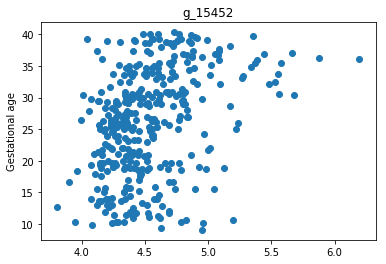

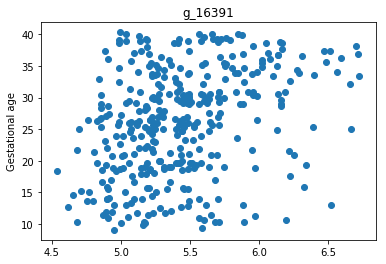

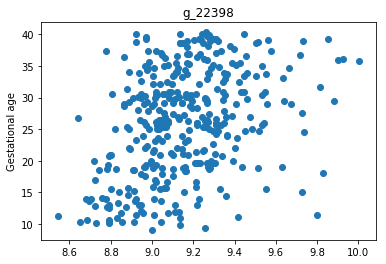

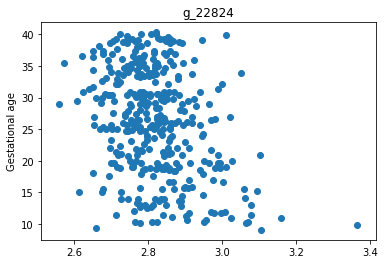

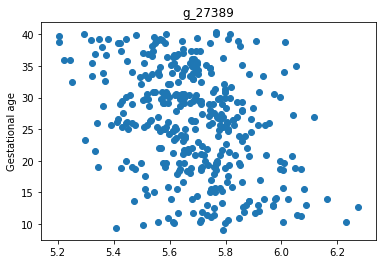

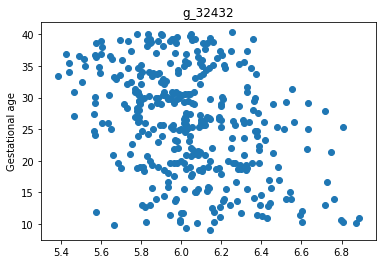

In [22]:
for i in np.arange(0, (df.shape[1]-1), 1):
    _ = plt.scatter(x = df[COLUMNS[i]], y = df['GA'])
    _ = plt.title(COLUMNS[i])
    _ = plt.ylabel('Gestational age')
    plt.show()

Most look like a linear relationship, no special things. I suppose for now, if I choose an appropriate number of features in lasso regression, I might improve my ranking in leadger board.

We split our training dataset into training dataset and validation dataset. In training dataset, we search grid of alpha and make several models with different number of features. And then, in the validation dataset, find the number of features which achieve the best accuracy.

# Train validation split

In [23]:
X_train = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830'].values
y_train = alldata.loc[alldata['Train'] == 1, 'GA'].values

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, test_size = 0.3, random_state = 21)

In each step, we store the information about the number of parameters whose absolute value is bigger than 0, the index of those parameters, and their coefficients. 

In [24]:
k = 10
a = 0.08
b = 0.17
alpha_space = np.linspace(a, b, num = k)
p_list = []
param_index_list = []
coef_list = []

for i in np.arange(0, k, 1):
    # Instantiate a lasso regression
    lasso = Lasso(alpha = alpha_space[i], normalize = True)

    # Fit lasso
    lasso.fit(X_train, y_train)

    # number of parameters
    p = sum(abs(lasso.coef_) > 0)

    # index of parameters
    param_index = np.where([abs(lasso.coef_) > 0])[1]

    # coefficients of parameters
    coef = lasso.coef_[abs(lasso.coef_) > 0]

    # store resutls
    p_list.append(p)
    param_index_list.append(param_index)
    coef_list.append(coef)

print(p_list)

[24, 21, 19, 12, 8, 8, 7, 5, 3, 2]


Actually I don't have to store the parameter index and each coefficients, because what I wanna know is the only information that achieve the best accuracy in the validation dataset. So I modify my code.

In [30]:
k = 10
a = 0.03
b = 0.17
alpha_space = np.linspace(a, b, num = k)

accuracy = []
p_list = []

for i in np.arange(0, k, 1):
    # Instantiate a lasso regression
    lasso = Lasso(alpha = alpha_space[i], normalize = True)

    # Fit lasso
    lasso.fit(X_train, y_train)

    # number of parameters
    p = sum(abs(lasso.coef_) > 0)

    # predict validation set
    y_pred = lasso.predict(X_vali)
    
    # accuracy
    rmse = math.sqrt(statistics.mean((y_vali - y_pred)**2))
    
    # store result
    accuracy.append(rmse)
    p_list.append(p)

print(accuracy)
print(p_list)

[7.26410380522211, 7.129444433955589, 7.277245271146074, 7.4714872754577835, 7.729282452818131, 8.009476172704417, 8.195899755402017, 8.37019362036897, 8.52326372997547, 8.646501757419898]
[114, 67, 43, 27, 21, 12, 8, 8, 5, 2]


Why does the model with many predictors have better accuracy?

In [33]:
alpha_space[np.argmin(accuracy)]

0.04555555555555556

# Hyperparameter tuning with GridSearchCV

In [35]:
# Setup the parameter grid
alpha_space = np.arange(0.01, 0.1, 0.01)
param_grid = {'alpha':alpha_space}

# Instantiate a lasso regression
lasso = Lasso(normalize = True)

# Instantiate the GridSearchCV object
lasso_cv = GridSearchCV(lasso, param_grid, cv = 10)

# Fit it to data
lasso_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned lasso regression parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))

C:\Users\yukic\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned lasso regression parameters: {'alpha': 0.04}
Best score is 0.3306733244806871


# Training accuracy by GridSearchCV

In [46]:
# predict train
y_pred = lasso_cv.predict(X_train)

# RMSE
math.sqrt(statistics.mean((y_train - y_pred)**2))

4.1855739226639175

# Check variables from GridSearchCV

In [44]:
# Run lasso regression
alpha = 0.04
lasso = Lasso(alpha = alpha, normalize = True)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

sum(abs(lasso_coef) > 0)

84

# Prediction in test set

In [48]:
COLUMNS = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830'].columns
var = pd.Series(COLUMNS[abs(lasso_coef) > 0])
coef = pd.Series(lasso_coef[abs(lasso_coef) > 0])
lasso_result = pd.concat(objs = [var, coef],
                         axis = 1,
                         keys = ['Variable', 'Lasso_coefficient'])
print(lasso_result)

   Variable  Lasso_coefficient
0     g_110           1.862604
1     g_484          -0.197969
2     g_966           0.163110
3    g_1318           0.072114
4    g_1453           0.377071
5    g_1953           2.012364
6    g_3468          -1.880732
7    g_3759           0.234664
8    g_3960           0.100381
9    g_4095           0.014637
10   g_4126           0.033769
11   g_4492          -0.510741
12   g_4994          -2.167656
13   g_5323           0.296196
14   g_5347          -0.249893
15   g_5475           2.040734
16   g_5687          -1.331722
17   g_5795          -2.718004
18   g_5825          -1.374470
19   g_6173           0.897351
20   g_6330          -0.360880
21   g_6452           2.237383
22   g_6631          -0.722724
23   g_6695           0.001689
24   g_6773           0.339069
25   g_7395          -0.158843
26   g_7422           0.805033
27   g_7821           0.477779
28   g_8114          -1.036198
29   g_8281          -0.070900
..      ...                ...
54  g_18

In [86]:
# rebuild model
X_train = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830']
y_train = alldata.loc[alldata['Train'] == 1, 'GA']
COLUMNS = lasso_result['Variable'].tolist()
X = X_train[COLUMNS].values
y = y_train.values
model = LinearRegression()
model.fit(X, y)

# predict test set
X_test = alldata.loc[alldata['Train'] == 0, 'g_1':'g_32830']
X_test = X_test[COLUMNS].values
test_pred = model.predict(X_test).round(1)
result = pd.concat([pd.Series(ID_test), pd.Series(test_pred)],
                  axis = 1,
                  keys = ['SampleID', 'GA'])
result.head()

,SampleID,GA
0,Tarca_003_P1A03,23.7
1,Tarca_006_P1A06,21.2
2,Tarca_011_P1A11,26.3
3,Tarca_012_P1A12,39.3
4,Tarca_015_P1B03,24.4


In [87]:
result['GA'].describe()

count    368.000000
mean      27.020380
std        7.350934
min        3.500000
25%       21.900000
50%       26.400000
75%       32.225000
max       46.100000
Name: GA, dtype: float64

# Correlation among predictors

In [88]:
COLUMNS = lasso_result['Variable'].tolist()
X_train = alldata.loc[alldata['Train'] == 1, COLUMNS]
corrmat = X_train.corr()
corrmat = corrmat.rename_axis(None).rename_axis(None, axis = 1)
corrmat = corrmat.stack().reset_index()
corrmat.columns = ['var_1', 'var_2', 'correlation']
corrmat = corrmat[corrmat['correlation'] != 1]
corrmat.sort_values(by = 'correlation', ascending = False).head(15)

,var_1,var_2,correlation
3996,g_17147,g_17294,0.630385
4079,g_17294,g_17147,0.630385
6697,g_29804,g_22158,0.627796
5203,g_22158,g_29804,0.627796
6937,g_30914,g_17516,0.582550
4198,g_17516,g_30914,0.582550
3432,g_14088,g_26984,0.525037
6088,g_26984,g_14088,0.525037
5432,g_22840,g_19437,0.514181
4768,g_19437,g_22840,0.514181


I forgot to check the p-values of those 84 predictors.

In [89]:
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     147.4
Date:                Tue, 09 Jul 2019   Prob (F-statistic):          1.19e-193
Time:                        20:51:23   Log-Likelihood:                -1037.8
No. Observations:                 367   AIC:                             2244.
Df Residuals:                     283   BIC:                             2572.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6606      1.767      1.506      0.1

Drop predictors which has high p-values.

In [90]:
COLUMNS = var[result.pvalues < 0.05]
COLUMNS

10     g_4126
20     g_6330
31     g_8660
46    g_17136
50    g_17631
68    g_25724
71    g_26873
72    g_26984
75    g_28914
79    g_29804
81    g_30426
82    g_30914
83    g_32432
dtype: object

With low p-value predictors, rebuild model

In [91]:
# rebuild model
X_train = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830']
y_train = alldata.loc[alldata['Train'] == 1, 'GA']
X = X_train[COLUMNS].values
y = y_train.values
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     556.5
Date:                Tue, 09 Jul 2019   Prob (F-statistic):          1.65e-226
Time:                        20:51:28   Log-Likelihood:                -1172.9
No. Observations:                 367   AIC:                             2372.
Df Residuals:                     354   BIC:                             2423.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             8.8541      3.296      2.686      0.0

Still one predictor is left with high p-value, so remove this predictor.

In [95]:
COLUMNS = COLUMNS[result.pvalues < 0.05]
COLUMNS

10     g_4126
20     g_6330
31     g_8660
46    g_17136
50    g_17631
68    g_25724
72    g_26984
75    g_28914
79    g_29804
81    g_30426
82    g_30914
83    g_32432
dtype: object

In [99]:
# rebuild model
X_train = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830']
y_train = alldata.loc[alldata['Train'] == 1, 'GA']
X = X_train[COLUMNS].values
y = y_train.values
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     600.3
Date:                Tue, 09 Jul 2019   Prob (F-statistic):          2.21e-227
Time:                        20:53:40   Log-Likelihood:                -1174.2
No. Observations:                 367   AIC:                             2372.
Df Residuals:                     355   BIC:                             2419.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             8.4212      3.291      2.559      0.0

In [100]:
# predict test set
X_test = alldata.loc[alldata['Train'] == 0, COLUMNS].values
test_pred = model.predict(X_test).round(1)
result = pd.concat([pd.Series(ID_test), pd.Series(test_pred)],
                  axis = 1,
                  keys = ['SampleID', 'GA'])
result.head()

,SampleID,GA
0,Tarca_003_P1A03,20.4
1,Tarca_006_P1A06,26.4
2,Tarca_011_P1A11,24.8
3,Tarca_012_P1A12,37.3
4,Tarca_015_P1B03,24.8


In [101]:
result['GA'].describe()

count    368.000000
mean      26.747011
std        6.385913
min        9.900000
25%       21.775000
50%       26.450000
75%       31.725000
max       47.700000
Name: GA, dtype: float64